In [10]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import sqlite3
import matplotlib.pyplot as plt

In [3]:
conn = sqlite3.connect("../database.db")

df = pd.read_sql("SELECT * FROM Ticker_1H WHERE Ticker = 'MSFT'", con=conn)
df.head()

,Datetime,Open,High,Low,Close,Volume,Ticker,InsertTime
0,2024-01-16 09:30:00.000000,392.750000,393.700012,389.470001,392.119995,8262760,MSFT,2026-01-13 11:05:14.285670
1,2024-01-16 10:30:00.000000,392.095001,393.220001,390.320007,391.649994,3330125,MSFT,2026-01-13 11:05:14.285670
2,2024-01-16 11:30:00.000000,391.690002,392.319885,389.730011,389.779999,2038955,MSFT,2026-01-13 11:05:14.285670
3,2024-01-16 12:30:00.000000,389.760010,390.000000,387.622894,389.010010,2296409,MSFT,2026-01-13 11:05:14.285670
4,2024-01-16 13:30:00.000000,389.019989,389.750000,388.000000,388.662994,1597837,MSFT,2026-01-13 11:05:14.285670


In [4]:
df.Ticker.drop_duplicates().to_numpy()

array(['MSFT'], dtype=object)

In [12]:
df = df[["Datetime", "Close"]]
df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.set_index("Datetime")
df.head()

,Close
Datetime,
2024-01-16 09:30:00,392.119995
2024-01-16 10:30:00,391.649994
2024-01-16 11:30:00,389.779999
2024-01-16 12:30:00,389.010010
2024-01-16 13:30:00,388.662994


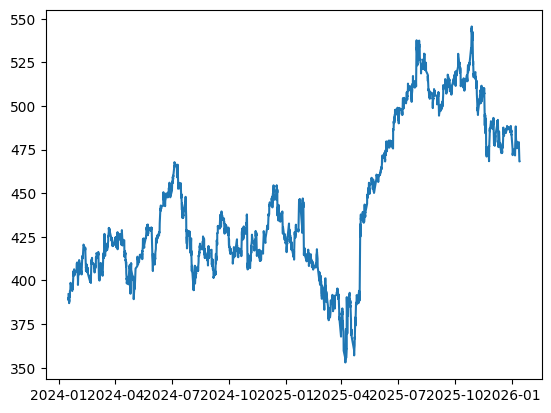

In [13]:
plt.plot(df.index, df.Close)

In [16]:
def create_window(df, window_size=5):
    df_np = df.to_numpy()
    X = []
    y = []


    for i in range(len(df_np) - window_size):
        row = [[a] for a in df_np[i:i+window_size]] # Does [[a] [b] [c]...]
        label = df_np[i+window_size]

        X.append(row)
        y.append(label)

    return np.array(X), np.array(y)

In [22]:
X, y = create_window(df, 5)
X.shape, y.shape

((3473, 5, 1, 1), (3473, 1))

In [23]:
X_train, y_train = X[:2800], y[:2800]
X_train, y_train = X[2800:3100], y[2800:3100]
X_train, y_train = X[3100:], y[3100:]